### This ananlysis uses FPL dataset from FPL API. The ultimate goal is to be able to build models so that we can predict player points for the upcoming FPL game week.

Specifically, we will: 
    
    1. Load in the FPL players datasets in JSON
    2. Build pandas dataframes for 22/23 season with current price
    3. Conduct some EDA
    4. Split the data into train and test
    5. Find the optimal parameters for each model and evaluate performance
    6. Fit the models for prediction
    7. Make prediction

    
Hopefully after this analysis we will be able to answer the following questions: 
 - How to obtain FPL dataset in desired format ready for analysis?
 - What are the valuable players based on previous season performance given current price?
 - What are some good predictors of FPL player points for the upcoming game week?
 - What predictors are correlated, therefore should be dropped before modelling?
 - How to construct modelling to balance bias and variance?
 - How to finetune model parameters to avoid overfitting?
 - What is the predicted player points for upcoming FPL game week using models trained?

In [341]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from bs4 import BeautifulSoup
import requests
import json
from IPython.display import HTML
from numpy.random import random
%matplotlib inline

import warnings
import chardet
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

#### A detailed guide to all currently available Fantasy Premier League API endpoints: 
https://medium.com/@frenzelts/fantasy-premier-league-api-endpoints-a-detailed-guide-acbd5598eb19

In [342]:
# function to request json over url
def getJson(base_url, end_point_path, element_id=''):
    return requests.get(base_url+end_point_path+str(element_id)).json()

In [343]:
# get json data
base_url = 'https://fantasy.premierleague.com/api/'
end_point_general = 'bootstrap-static'
end_point_fixtures = 'fixtures'
end_point_player = 'element-summary/'

json = getJson(base_url, end_point_general)
# check keys
json.keys()

dict_keys(['events', 'game_settings', 'phases', 'teams', 'total_players', 'elements', 'element_stats', 'element_types'])

#### Desired data
##### Dataframe #1:
- all 38 game week of season 22/23
- all 10 games of each 38 game week of season 22/23
- all players involved [i.e. ~(11 + 4) x 2] for all 10 games in each 38 game week of season 22/23

Expected number of records = 38 x 10 x (11 + 4) x 2 = ~11.4K

##### Dataframe #2:
- current player info including cost, position etc.

##### Dataframe #3:
- Join df1 and df2 to get aggregated df for info such as value = average points per minute / current cost

In [344]:
# build dataframes
df_elements = pd.DataFrame(json['elements'])
df_elements_types = pd.DataFrame(json['element_types'])
df_teams = pd.DataFrame(json['teams'])
total_players = json['total_players']
percentile = 0.8

df_elements_short = df_elements[['id', 'first_name', 'second_name','team','element_type','selected_by_percent','now_cost','minutes','transfers_in','value_season','event_points', 'total_points']]

# restructure player dataframe
df_elements_short['position'] = df_elements_short.element_type.map(df_elements_types.set_index('id').singular_name)
df_elements_short['team'] = df_elements_short.team.map(df_teams.set_index('id').name)
df_elements_short['name'] = df_elements_short['first_name'] + ' ' + df_elements_short['second_name']
df_elements_short['points_per_minute'] = df_elements_short['total_points'] / df_elements_short['minutes']
df_elements_short['points_per_minute'] = df_elements_short['points_per_minute'].fillna(0)
df_elements_short['now_cost'] = df_elements_short['now_cost'] / 10
df_elements_short['ppm_over_cost'] = df_elements_short['points_per_minute'] / df_elements_short['now_cost']
df_elements_short = df_elements_short[df_elements_short['minutes'] >= df_elements_short['minutes'].quantile(percentile)]
df_elements_short = df_elements_short[['id', 'name', 'team', 'position', 'selected_by_percent', 'minutes', 'now_cost', 'points_per_minute', 'ppm_over_cost']]

In [345]:
# show value players
df_elements_short = df_elements_short.sort_values(by=['ppm_over_cost'], ascending=False)
df_elements_short.groupby(['position']).head(5)

,id,name,team,position,selected_by_percent,minutes,now_cost,points_per_minute,ppm_over_cost
25,26,Leandro Trossard,Arsenal,Midfielder,2.7,2237,7.0,0.068842,0.009835
420,402,Miguel Almirón Rejala,Newcastle,Midfielder,6.2,2487,6.5,0.063530,0.009774
285,275,Bernd Leno,Fulham,Goalkeeper,9.0,3240,4.5,0.043827,0.009739
117,113,David Raya Martin,Brentford,Goalkeeper,9.7,3420,5.0,0.048538,0.009708
19,20,William Saliba,Arsenal,Defender,14.8,2415,5.0,0.048447,0.009689
155,151,Joël Veltman,Brighton,Defender,1.3,2183,4.5,0.043518,0.009671
521,495,Ben Davies,Spurs,Defender,0.7,2284,4.5,0.043345,0.009632
135,131,Pervis Estupiñán,Brighton,Defender,51.1,2674,5.0,0.047868,0.009574
394,377,Diogo Dalot Teixeira,Man Utd,Defender,2.0,2152,5.0,0.047398,0.009480
233,226,Eberechi Eze,Crystal Palace,Midfielder,12.0,2631,6.5,0.060433,0.009297


In [346]:
df_mo = df_elements_short[(df_elements_short['name']=='Mohamed Salah')]
df_mo

,id,name,team,position,selected_by_percent,minutes,now_cost,points_per_minute,ppm_over_cost
319,308,Mohamed Salah,Liverpool,Midfielder,24.5,3290,12.5,0.072644,0.005812


In [347]:
element_id = 308
json = getJson(base_url, end_point_player, element_id)
# check keys
json.keys()

dict_keys(['fixtures', 'history', 'history_past'])

In [348]:
df_player_mo = pd.DataFrame(json['history_past'])
df_player_mo.tail()

,season_name,element_code,start_cost,end_cost,total_points,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,starts,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded
3,2018/19,118748,130,132,259,3254,22,12,21,20,0,0,0,1,0,0,18,687,1186.8,973.9,2168.0,432.7,0,0.00,0.00,0.00,0.00
4,2019/20,118748,125,125,233,2879,19,10,16,26,0,0,0,1,0,0,26,661,1061.2,834.8,2156.0,405.1,0,0.00,0.00,0.00,0.00
5,2020/21,118748,120,129,231,3077,22,6,11,41,0,0,0,0,0,0,21,657,1056.0,825.7,1980.0,385.8,0,0.00,0.00,0.00,0.00
6,2021/22,118748,125,131,265,2758,23,14,17,22,0,0,1,1,0,0,29,756,1241.0,875.9,2230.0,434.8,0,0.00,0.00,0.00,0.00
7,2022/23,118748,130,131,239,3290,19,13,13,45,0,0,2,2,0,0,23,651,1067.4,899.2,1688.0,365.6,37,21.01,7.03,28.04,47.47


##### Data limiation
From observation above, FPL API doesn't have player level game week data for past seasons

##### Solution
Use github repo https://github.com/vaastav/Fantasy-Premier-League/tree/master loaded to local repo

In [349]:
# helper functions to retrieve players master dataframe based on seasons interested
def getEncoding(file):
    with open(file, 'rb') as rawdata:
        result = chardet.detect(rawdata.read(100000))
    return result['encoding']

def getMasterDataFrame(seasons):
    for i, season in enumerate(seasons):

        file = 'Fantasy-Premier-League/data/'+ season +'/gws/merged_gw.csv'
        encoding = getEncoding(file)

        if i == 0:
            df_master = pd.read_csv(file, encoding=encoding)
            df_master['season'] = season
        else:
            df_temp = pd.read_csv(file, encoding=encoding)
            df_temp['season'] = season
            df_master = pd.concat([df_master, df_temp], ignore_index=True)
    return df_master

In [350]:
# retrieve player master dataframe by specifying seasons intended to pull
# i.e. to pull player data for season 22/23, assign seasons = ['2022-23']
seasons = ['2022-23']

df_master = getMasterDataFrame(seasons)

df_master = df_master.merge(df_elements_short[['name','selected_by_percent', 'now_cost']], on='name', how='right')

In [374]:
# validation with seasonally aggregated data for Salah above
df_mo = df_master[df_master['name'].str.contains('Salah')]
df_mo.groupby(['season'])['minutes'].sum()

season
2022-23    3290.0
Name: minutes, dtype: float64

Validation complete, numbers match for seasons 22/23, 21/22 and 20/21

In [394]:
# calculate efficient frontier player metrics
df_eft_raw = df_master[['name', 'team', 'element', 'total_points', 'minutes', 'season', 'now_cost']]
df_eft_raw['points_return'] = df_eft_raw['total_points'] / df_eft_raw['now_cost']
df_eft_raw['ptspm_return'] = (df_eft_raw['total_points'] / df_eft_raw['minutes']) / df_eft_raw['now_cost']

def getEfficientFrontierDF(df_eft_raw, df_live, return_str):
    df_std = df_eft_raw.groupby(['name', 'team'])[return_str].std().reset_index()
    df_std = df_std.rename(columns={df_std.columns[0]: 'name', df_std.columns[1]: 'team', df_std.columns[2]: 'pts_rt_std'})
    df_rt = df_eft_raw.groupby(['name', 'team'])[return_str].mean().reset_index()
    df_rt = df_rt.rename(columns={df_rt.columns[0]: 'name', df_rt.columns[1]: 'team', df_rt.columns[2]: 'ave_pts_rt'})
    df_eft = df_rt.merge(df_std, on=['name', 'team'], how='left')
    df_eft['adj_pts_rt'] = df_eft['ave_pts_rt'] / df_eft['pts_rt_std']
    df_eft = df_eft.merge(df_live[['name', 'team', 'position', 'selected_by_percent', 'now_cost']], on=['name', 'team'], how='right')
    
    # eleminate bottom 30 percent in terms of average points returned as % of current price
    df_eft = df_eft[df_eft['ave_pts_rt'] >= df_eft['ave_pts_rt'].quantile(0.3)]
    return df_eft.sort_values(by=['adj_pts_rt'], ascending=False)

df_eft = getEfficientFrontierDF(df_eft_raw, df_elements_short, 'points_return')
df_eft.head(20)

,name,team,ave_pts_rt,pts_rt_std,adj_pts_rt,position,selected_by_percent,now_cost
105,Harry Kane,Spurs,0.553684,0.292542,1.892668,Forward,14.0,12.5
3,David Raya Martin,Brentford,0.873684,0.556866,1.568931,Goalkeeper,9.7,5.0
10,Benjamin White,Arsenal,0.746411,0.499791,1.493446,Defender,9.7,5.5
19,Kieran Trippier,Newcastle,0.801619,0.583540,1.373719,Defender,34.6,6.5
101,Bruno Borges Fernandes,Man Utd,0.544892,0.402388,1.354145,Midfielder,25.2,8.5
36,Aaron Ramsdale,Arsenal,0.752632,0.558829,1.346801,Goalkeeper,24.0,5.0
17,Sven Botman,Newcastle,0.754386,0.560136,1.346791,Defender,26.1,4.5
86,Alex Iwobi,Everton,0.602871,0.449565,1.341008,Midfielder,0.7,5.5
111,Mohamed Salah,Liverpool,0.503158,0.377947,1.331293,Midfielder,24.5,12.5
22,Gabriel Martinelli Silva,Arsenal,0.651316,0.492475,1.322535,Midfielder,14.3,8.0


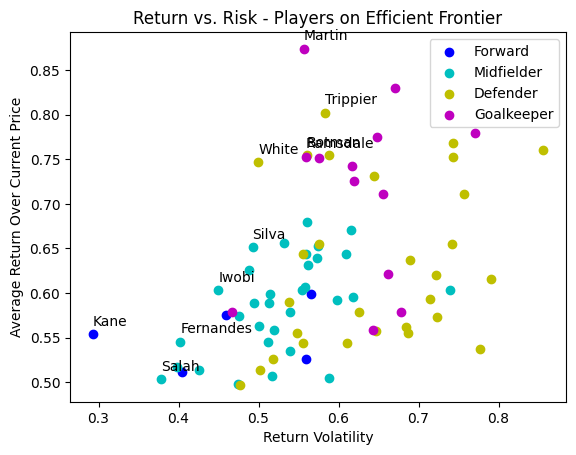

In [399]:
# plot efficient frontier players
def plotEfficientFrontier(df_eft, y_offset, y_lable, x_max = None, x_min = None, y_max = None, y_min = None):
    colors = {'Forward': 'b', 'Midfielder': 'c', 'Defender': 'y', 'Goalkeeper': 'm'}

    for i, position in enumerate(colors.keys()):

        df = df_eft[df_eft['position'] == position]
        x = list(df['pts_rt_std'])
        y = list(df['ave_pts_rt'])
        plt.scatter(x, y, color=colors[position])
        for j, player in enumerate(df['name']):
            if float(list(df['adj_pts_rt'])[j]) >= df['adj_pts_rt'].quantile(0.9):
                plt.annotate(player.split(' ')[-1], (x[j], y[j] + y_offset))

    plt.legend(colors.keys(),
            bbox_to_anchor=(1 , 1),
            ncol=1)
    plt.title('Return vs. Risk - Players on Efficient Frontier')
    plt.xlabel('Return Volatility')
    plt.ylabel(y_lable)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.show()

plotEfficientFrontier(df_eft, 0.01, 'Average Return Over Current Price')

##### Using average game week return over current price as the numerator penalizes player's injury and assumes long-term player ownership
##### Use average return per minute over current price as the numerator below to avoid bias

In [400]:
df_eft_adj = getEfficientFrontierDF(df_eft_raw, df_elements_short, 'ptspm_return')
df_eft_adj.head(50)

,name,team,ave_pts_rt,pts_rt_std,adj_pts_rt,position,selected_by_percent,now_cost
62,Sean Longstaff,Newcastle,0.008055,0.003905,2.062893,Midfielder,0.2,5.0
3,David Raya Martin,Brentford,0.009708,0.006187,1.568931,Goalkeeper,9.7,5.0
38,Andreas Hoelgebaum Pereira,Fulham,0.008128,0.005267,1.543249,Midfielder,3.6,5.5
27,Joe Willock,Newcastle,0.008661,0.005727,1.512193,Midfielder,1.1,5.5
0,Leandro Trossard,Arsenal,0.011563,0.007906,1.462607,Midfielder,2.7,7.0
11,Dan Burn,Newcastle,0.009552,0.006631,1.440494,Defender,3.3,4.5
49,Kenny Tete,Fulham,0.007956,0.005597,1.421591,Defender,0.6,4.5
54,Lucas Tolentino Coelho de Lima,West Ham,0.007621,0.005493,1.387251,Midfielder,1.5,6.0
19,Kieran Trippier,Newcastle,0.009090,0.006622,1.372815,Defender,34.6,6.5
10,Benjamin White,Arsenal,0.009931,0.007297,1.360858,Defender,9.7,5.5


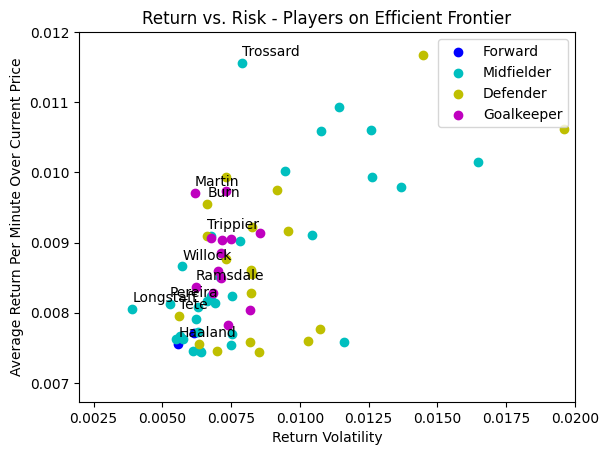

In [401]:
plotEfficientFrontier(df_eft_adj, 0.0001, 'Average Return Per Minute Over Current Price', x_max=0.02, y_max=0.012)

##### Data limiation
Predictors from FPL (i.e. threat, ICT index, influence) are most lagging indicators, lack of player attributes predictors

##### Solution
Feature engineer player attribute predictors from Football Manager

In [402]:
df_master = df_master[df_master['season'] == '2022-23']
df_master.head()

,name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,element,expected_assists,expected_goal_involvements,expected_goals,expected_goals_conceded,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,starts,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW,season,selected_by_percent,now_cost
0,Leandro Trossard,MID,Brighton,1.8,0.0,0.0,7.0,0.0,40.9,111.0,0.0,0.0,0.0,0.0,9.0,1.0,0.0,6.9,8.0,2022-08-07T13:00:00Z,74.0,14.0,0.0,0.0,0.0,0.0,1.0,0.0,177238.0,0.0,2.0,1.0,20.0,1.0,0.0,0.0,0.0,65.0,False,1.0,1.0,2022-23,2.7,7.0
1,Leandro Trossard,MID,Brighton,2.0,0.0,0.0,4.0,1.0,3.2,111.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,3.6,1.8,2022-08-13T14:00:00Z,74.0,15.0,0.0,0.0,0.0,0.0,2.0,0.0,203115.0,0.0,0.0,0.0,31.0,3.0,4067.0,27136.0,23069.0,65.0,True,0.0,2.0,2022-23,2.7,7.0
2,Leandro Trossard,MID,Brighton,4.0,0.0,0.0,25.0,1.0,26.3,111.0,0.0,0.0,0.0,0.0,30.0,0.0,1.0,14.3,35.6,2022-08-21T13:00:00Z,90.0,19.0,0.0,0.0,0.0,0.0,3.0,0.0,198215.0,0.0,2.0,0.0,81.0,8.0,-11788.0,26387.0,38175.0,65.0,False,0.0,3.0,2022-23,2.7,7.0
3,Leandro Trossard,MID,Brighton,5.0,1.0,0.0,15.0,1.0,21.8,111.0,0.0,0.0,0.0,0.0,34.0,0.0,0.0,7.3,19.0,2022-08-27T14:00:00Z,78.0,11.0,0.0,0.0,0.0,0.0,4.0,0.0,239745.0,0.0,0.0,1.0,32.0,6.0,28568.0,52808.0,24240.0,65.0,True,0.0,4.0,2022-23,2.7,7.0
4,Leandro Trossard,MID,Brighton,4.5,0.0,0.0,7.0,0.0,16.8,111.0,0.0,0.0,0.0,0.0,44.0,2.0,0.0,5.3,11.4,2022-08-30T18:30:00Z,90.0,9.0,0.0,0.0,0.0,0.0,5.0,0.0,271436.0,0.0,1.0,2.0,25.0,2.0,25305.0,46240.0,20935.0,65.0,False,0.0,5.0,2022-23,2.7,7.0


In [403]:
file_fm = 'FM/FM 2023.csv'

encoding = getEncoding(file_fm)

df_fm = pd.read_csv(file_fm, encoding = encoding)

df_fm = df_fm.drop_duplicates()

df_fm.head()

,Name,Position,Age,ca,pa,Nationality,Club,Corners,Crossing,Dribbling,Finishing,First Touch,Free Kick Taking,Heading,Long Shots,Long Throws,Marking,Passing,Penalty Taking,Tackling,Technique,Aggressiion,Anticipation,Bravery,Composure,Concentration,Vision,Decision,Determination,Flair,Leadership,Off The Ball,Position.1,Teamwork,Work Rate,Acceleration,Agility,Balance,Jumping Reach,Natural Fitness,Pace,Stamina,Strength,Stability,Foul,Contest performance,Injury,diversity,Aerial Reach,Command Of Area,Communication,Eccentricity,Handling,Kicking,One On Ones,Reflexes,Rushing Out,Punching,Throwing,Adaptation,Ambition,Argue,Loyal,Resistant to stress,Professional,Sportsmanship,Emotional control,GK,DL,DC,DR,WBL,WBR,DM,ML,MC,MR,AML,AMC,AMR,ST,Height,Weight,Left Foot,Right Foot,Values,Current reputation,Domestic reputation,World reputation,Race,RCA,Colour of skin,Date of birth,Number of national team appearances,Goals scored for the national team,Salary,Rental club,UID
0,Kevin De Bruyne,M/AM RLC,31,189,189,Belgium,Manchester City,14,19,15,16,16,17,6,17,7,9,18,16,9,18,12,14,13,15,15,20,18,17,16,13,14,11,14,15,15,13,14,10,16,14,17,13,15,6,15,7,14,1,3,1,3,3,3,3,3,3,2,1,13,17,13,14,11,18,16,13,1,1,1,1,1,1,12,15,20,15,14,20,14,12,181,68,16,20,347975206,9450,9400,9400,Northern_European,181,4,1991/6/28,91,24,394372.0,NaN,18004457
1,Kylian Mbappé,AM/S RL,23,188,197,France,Paris Saint-Germain,13,13,18,17,18,12,7,13,4,4,15,18,4,17,6,17,12,18,14,15,15,15,18,13,18,3,10,10,20,16,15,8,15,20,14,11,15,7,16,7,14,2,2,2,1,1,2,1,3,2,1,2,15,20,8,14,16,16,12,13,1,1,1,1,1,1,1,10,1,10,19,1,17,20,178,73,10,20,347975206,9398,9398,9248,African_Caribbean,172,13,1998/12/20,57,27,1035616.0,NaN,85139014
2,Robert Lewandowski,S,33,186,190,Poland,Barcelona,3,8,13,19,18,15,17,12,3,7,13,20,7,16,15,19,16,17,17,13,17,20,14,15,19,7,12,12,14,13,19,15,20,14,18,16,18,8,15,2,8,2,2,3,2,3,2,3,3,2,1,1,15,20,15,10,16,18,10,11,1,1,1,1,1,1,1,1,1,1,10,12,8,20,185,81,13,20,347975206,9300,9400,9250,Northern_European,183,3,1988/8/21,132,76,345204.0,NaN,719601
3,Erling Haaland,S,22,185,195,"Norway,England",Manchester City,7,10,14,18,16,13,15,13,5,6,13,17,7,15,13,18,15,18,15,14,13,20,16,13,18,7,13,13,17,16,17,18,19,19,14,17,17,9,17,12,10,2,4,1,3,2,2,2,2,3,3,2,16,20,12,15,18,17,10,12,1,1,1,1,1,1,1,1,1,1,1,1,1,20,195,88,20,11,347975206,9250,9250,8750,Northern_European,185,2,2000/7/21,21,20,394372.0,NaN,29179241
4,Mohamed Salah,AM/S RL,30,185,187,Egypt,Liverpool,12,14,17,17,17,12,10,13,6,7,15,17,7,17,11,16,11,15,15,17,15,18,15,11,18,9,15,16,18,16,18,8,17,18,15,15,15,6,16,4,7,3,2,2,1,2,1,3,2,3,3,2,16,19,8,13,16,18,16,17,1,1,1,1,1,1,1,1,1,1,17,12,20,19,175,72,20,8,347975206,9400,9445,8750,North_African__Middle_Eastern,181,9,1992/6/15,85,47,405971.0,NaN,98028755


In [404]:
# find player name in FM mannually before join FM data
name_match_list_fm = [['Miguel Almirón Rejala', 'Miguel Almirón'], 
                        ['David Raya Martin', 'David Raya'],
                        ['Diogo Dalot Teixeira', 'Diogo Dalot'],
                        ['Eberechi Eze', 'Ebere Eze'],
                        ['José Malheiro de Sá', 'José Sá'],
                        ['Lukasz Fabianski', 'Łukasz Fabiański'],
                        ['Gabriel Martinelli Silva', 'Gabriel Martinelli'],
                        ['Alisson Ramses Becker', 'Alisson'],
                        ['Douglas Luiz Soares de Paulo', 'Douglas Luiz'],
                        ['Norberto Murara Neto', 'Pedro Neto'],
                        ['Emiliano Martínez Romero', 'Emiliano Martínez'],
                        ['Gabriel dos Santos Magalhães', 'Gabriel'],
                        ['Andreas Hoelgebaum Pereira', 'Andreas Pereira'],
                        ['Emiliano Buendía Stati', 'Emiliano Buendía'],
                        ['Lucas Tolentino Coelho de Lima', 'Lucas Paquetá'],
                        ['Bernardo Veiga de Carvalho e Silva', 'Bernardo Silva'],
                        ['Ezri Konsa Ngoyo', 'Ezri Konsa'],
                        ['Joelinton Cássio Apolinário de Lira', 'Joelinton'],
                        ['Ederson Santana de Moraes', 'Ederson'],
                        ['Thiago Emiliano da Silva', 'Thiago Silva'],
                        ['Rodrigo Hernandez', 'Rodri'],
                        ['Bobby De Cordova-Reid', 'Bobby Decordova-Reid'],
                        ['Bruno Guimarães Rodriguez Moura', 'Bruno Guimarães'],
                        ['Matheus Luiz Nunes', 'Matheus Nunes'],
                        ['Nélson Cabral Semedo', 'Nélson Semedo'],
                        ['Vitalii Mykolenko', 'Vitaliy Mykolenko'],
                        ['Bruno Borges Fernandes', 'Bruno Fernandes'],
                        ['Jefferson Lerma Solís', 'Jefferson Lerma'],
                        ['Son Heung-min', 'Heung-Min Son'],
                        ['João Palhinha Gonçalves', 'João Palhinha'],
                        ['Fabio Henrique Tavares', 'Fabinho2'],
                        ['Moisés Caicedo Corozo', 'Moisés Caicedo']]
df_name_match_fm = pd.DataFrame(name_match_list_fm, columns=['fpl_name', 'fm_name'])

df_fm = df_fm.merge(df_name_match_fm, left_on=['Name'], right_on=['fm_name'], how='left')

In [405]:
df_fm['Merged_Name'] = np.where(df_fm['fpl_name'].notna(), df_fm['fpl_name'], df_fm['Name'])
df_fm.head()

,Name,Position,Age,ca,pa,Nationality,Club,Corners,Crossing,Dribbling,Finishing,First Touch,Free Kick Taking,Heading,Long Shots,Long Throws,Marking,Passing,Penalty Taking,Tackling,Technique,Aggressiion,Anticipation,Bravery,Composure,Concentration,Vision,Decision,Determination,Flair,Leadership,Off The Ball,Position.1,Teamwork,Work Rate,Acceleration,Agility,Balance,Jumping Reach,Natural Fitness,Pace,Stamina,Strength,Stability,Foul,Contest performance,Injury,diversity,Aerial Reach,Command Of Area,Communication,Eccentricity,Handling,Kicking,One On Ones,Reflexes,Rushing Out,Punching,Throwing,Adaptation,Ambition,Argue,Loyal,Resistant to stress,Professional,Sportsmanship,Emotional control,GK,DL,DC,DR,WBL,WBR,DM,ML,MC,MR,AML,AMC,AMR,ST,Height,Weight,Left Foot,Right Foot,Values,Current reputation,Domestic reputation,World reputation,Race,RCA,Colour of skin,Date of birth,Number of national team appearances,Goals scored for the national team,Salary,Rental club,UID,fpl_name,fm_name,Merged_Name
0,Kevin De Bruyne,M/AM RLC,31,189,189,Belgium,Manchester City,14,19,15,16,16,17,6,17,7,9,18,16,9,18,12,14,13,15,15,20,18,17,16,13,14,11,14,15,15,13,14,10,16,14,17,13,15,6,15,7,14,1,3,1,3,3,3,3,3,3,2,1,13,17,13,14,11,18,16,13,1,1,1,1,1,1,12,15,20,15,14,20,14,12,181,68,16,20,347975206,9450,9400,9400,Northern_European,181,4,1991/6/28,91,24,394372.0,NaN,18004457,NaN,NaN,Kevin De Bruyne
1,Kylian Mbappé,AM/S RL,23,188,197,France,Paris Saint-Germain,13,13,18,17,18,12,7,13,4,4,15,18,4,17,6,17,12,18,14,15,15,15,18,13,18,3,10,10,20,16,15,8,15,20,14,11,15,7,16,7,14,2,2,2,1,1,2,1,3,2,1,2,15,20,8,14,16,16,12,13,1,1,1,1,1,1,1,10,1,10,19,1,17,20,178,73,10,20,347975206,9398,9398,9248,African_Caribbean,172,13,1998/12/20,57,27,1035616.0,NaN,85139014,NaN,NaN,Kylian Mbappé
2,Robert Lewandowski,S,33,186,190,Poland,Barcelona,3,8,13,19,18,15,17,12,3,7,13,20,7,16,15,19,16,17,17,13,17,20,14,15,19,7,12,12,14,13,19,15,20,14,18,16,18,8,15,2,8,2,2,3,2,3,2,3,3,2,1,1,15,20,15,10,16,18,10,11,1,1,1,1,1,1,1,1,1,1,10,12,8,20,185,81,13,20,347975206,9300,9400,9250,Northern_European,183,3,1988/8/21,132,76,345204.0,NaN,719601,NaN,NaN,Robert Lewandowski
3,Erling Haaland,S,22,185,195,"Norway,England",Manchester City,7,10,14,18,16,13,15,13,5,6,13,17,7,15,13,18,15,18,15,14,13,20,16,13,18,7,13,13,17,16,17,18,19,19,14,17,17,9,17,12,10,2,4,1,3,2,2,2,2,3,3,2,16,20,12,15,18,17,10,12,1,1,1,1,1,1,1,1,1,1,1,1,1,20,195,88,20,11,347975206,9250,9250,8750,Northern_European,185,2,2000/7/21,21,20,394372.0,NaN,29179241,NaN,NaN,Erling Haaland
4,Mohamed Salah,AM/S RL,30,185,187,Egypt,Liverpool,12,14,17,17,17,12,10,13,6,7,15,17,7,17,11,16,11,15,15,17,15,18,15,11,18,9,15,16,18,16,18,8,17,18,15,15,15,6,16,4,7,3,2,2,1,2,1,3,2,3,3,2,16,19,8,13,16,18,16,17,1,1,1,1,1,1,1,1,1,1,17,12,20,19,175,72,20,8,347975206,9400,9445,8750,North_African__Middle_Eastern,181,9,1992/6/15,85,47,405971.0,NaN,98028755,NaN,NaN,Mohamed Salah


In [406]:
df_insights = df_master.merge(df_fm, left_on=['name'], right_on=['Merged_Name'], how='left')
df_insights.describe()

,xP,assists,bonus,bps,clean_sheets,creativity,element,expected_assists,expected_goal_involvements,expected_goals,expected_goals_conceded,fixture,goals_conceded,goals_scored,ict_index,influence,minutes,opponent_team,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,starts,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,yellow_cards,GW,now_cost,Age,ca,pa,Corners,Crossing,Dribbling,Finishing,First Touch,Free Kick Taking,Heading,Long Shots,Long Throws,Marking,Passing,Penalty Taking,Tackling,Technique,Aggressiion,Anticipation,Bravery,Composure,Concentration,Vision,Decision,Determination,Flair,Leadership,Off The Ball,Position.1,Teamwork,Work Rate,Acceleration,Agility,Balance,Jumping Reach,Natural Fitness,Pace,Stamina,Strength,Stability,Foul,Contest performance,Injury,diversity,Aerial Reach,Command Of Area,Communication,Eccentricity,Handling,Kicking,One On Ones,Reflexes,Rushing Out,Punching,Throwing,Adaptation,Ambition,Argue,Loyal,Resistant to stress,Professional,Sportsmanship,Emotional control,GK,DL,DC,DR,WBL,WBR,DM,ML,MC,MR,AML,AMC,AMR,ST,Height,Weight,Left Foot,Right Foot,Values,Current reputation,Domestic reputation,World reputation,RCA,Colour of skin,Number of national team appearances,Goals scored for the national team,Salary,UID
count,4573.000000,4573.00000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4.573000e+03,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4.573000e+03,4.573000e+03,4.573000e+03,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.00000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4.573000e+03,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4573.000000,4.573000e+03
mean,3.333304,0.10059,0.290619,14.027990,0.255194,11.031227,257.075443,0.046715,0.109614,0.071504,0.720706,191.153728,1.059042,0.107807,3.794249,16.487470,73.427728,10.561994,0.004592,0.002624,0.001968,0.001531,20.370873,0.311830,7.820544e+05,0.530724,1.222830,1.628253,10.403236,3.193527,1.487178e+04,5.462081e+04,3.974902e+04,55.683359,0.125082,20.370873,5.755740,26.396239,145.241198,150.629565,8.373934,10.379401,11.798819,9.386617,13.261535,8.968511,10.764706,9.552591,6.890663,9.963044,13.513667,9.296523,11.300459,13.544063,12.246009,13.767111,13.480429,13.568992,12.995408,12.881260,13.142795,14.407173,11.254319,10.703040,11.905095,12.223048,14.321671,14.445222,13.311393,13.387273,13.058168,11.911218,14.354909,13.509075,14.336103,12.722939,13.541876,8.607697,13.228515,7.311174,11.347912,3.315985,3.453313,3.371529,3.059917,3.611634,3.304833,3.576427,3.529412,3.460967,3.163131,3.164662,13.282747,14.177127,6.481522,12.442161,13.11874,14.745462,12.144981,13.116772,3.052482,5.046796,7.083752,3.789635,4.054231,3.298491,6.373934,5.345725,7.993658,5.282309,6.285589,7.082878,6.254975,4.817844,183.185874,73.771922,13.880166

In [407]:
df_insights['name'].nunique()

120

In [408]:
# ensure this returns an empty array to ensure player mapping complete
# otherwise more manual mapping on player name required
df_insights[df_insights['Age'].isna()]['name'].unique()

array([], dtype=object)

In [337]:
# ways to look around to match player name between FPL and FM
# df_insights[df_insights['name'].str.contains('João Palhinha Gonçalves')].head()


# name_try = 'Moisés Caicedo'
# df_fm[df_fm['Name'].str.contains(name_try)]

# club_try = 'West Ham'
# df_fm[df_fm['Club'].str.contains(club_try, na=False)]

In [409]:
df_insights.head()

,name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,element,expected_assists,expected_goal_involvements,expected_goals,expected_goals_conceded,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,starts,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW,season,selected_by_percent,now_cost,Name,Position,Age,ca,pa,Nationality,Club,Corners,Crossing,Dribbling,Finishing,First Touch,Free Kick Taking,Heading,Long Shots,Long Throws,Marking,Passing,Penalty Taking,Tackling,Technique,Aggressiion,Anticipation,Bravery,Composure,Concentration,Vision,Decision,Determination,Flair,Leadership,Off The Ball,Position.1,Teamwork,Work Rate,Acceleration,Agility,Balance,Jumping Reach,Natural Fitness,Pace,Stamina,Strength,Stability,Foul,Contest performance,Injury,diversity,Aerial Reach,Command Of Area,Communication,Eccentricity,Handling,Kicking,One On Ones,Reflexes,Rushing Out,Punching,Throwing,Adaptation,Ambition,Argue,Loyal,Resistant to stress,Professional,Sportsmanship,Emotional control,GK,DL,DC,DR,WBL,WBR,DM,ML,MC,MR,AML,AMC,AMR,ST,Height,Weight,Left Foot,Right Foot,Values,Current reputation,Domestic reputation,World reputation,Race,RCA,Colour of skin,Date of birth,Number of national team appearances,Goals scored for the national team,Salary,Rental club,UID,fpl_name,fm_name,Merged_Name
0,Leandro Trossard,MID,Brighton,1.8,0.0,0.0,7.0,0.0,40.9,111.0,0.0,0.0,0.0,0.0,9.0,1.0,0.0,6.9,8.0,2022-08-07T13:00:00Z,74.0,14.0,0.0,0.0,0.0,0.0,1.0,0.0,177238.0,0.0,2.0,1.0,20.0,1.0,0.0,0.0,0.0,65.0,False,1.0,1.0,2022-23,2.7,7.0,Leandro Trossard,WB/M/AM LC,27,152,157,Belgium,Brighton & Hove Albion,14,12,15,14,14,12,5,13,4,6,14,15,4,16,13,12,13,13,14,15,13,11,15,8,15,9,10,12,16,13,13,6,10,15,13,9,14,8,15,8,17,1,2,3,1,3,2,2,1,2,3,2,12,14,6,8,12,11,12,11,1,1,1,1,17,1,1,17,1,1,20,19,14,15,172,67,15,20,50900273,7600,7600,6250,Northern_European,143,2,1994/12/4,19,5,69595.0,NaN,18054004,NaN,NaN,Leandro Trossard
1,Leandro Trossard,MID,Brighton,2.0,0.0,0.0,4.0,1.0,3.2,111.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,3.6,1.8,2022-08-13T14:00:00Z,74.0,15.0,0.0,0.0,0.0,0.0,2.0,0.0,203115.0,0.0,0.0,0.0,31.0,3.0,4067.0,27136.0,23069.0,65.0,True,0.0,2.0,2022-23,2.7,7.0,Leandro Trossard,WB/M/AM LC,27,152,157,Belgium,Brighton & Hove Albion,14,12,15,14,14,12,5,13,4,6,14,15,4,16,13,12,13,13,14,15,13,11,15,8,15,9,10,12,16,13,13,6,10,15,13,9,14,8,15,8,17,1,2,3,1,3,2,2,1,2,3,2,12,14,6,8,12,11,12,11,1,1,1,1,17,1,1,17,1,1,20,19,14,15,172,67,15,20,50900273,7600,7600,6250,Northern_European,143,2,1994/12/4,19,5,69595.0,NaN,18054004,NaN,NaN,Leandro Trossard
2,Leandro Trossard,MID,Brighton,4.0,0.0,0.0,25.0,1.0,26.3,111.0,0.0,0.0,0.0,0.0,30.0,0.0,1.0,14.3,35.6,2022-08-21T13:00:00Z,90.0,19.0,0.0,0.0,0.0,0.0,3.0,0.0,198215.0,0.0,2.0,0.0,81.0,8.0,-11788.0,26387.0,38175.0,65.0,False,0.0,3.0,2022-23,2.7,7.0,Leandro Trossard,WB/M/AM LC,27,152,157,Belgium,Brighton & Hove Albion,14,12,15,14,14,12,5,13,4,6,14,15,4,16,13,12,13,13,14,15,13,11,15,8,15,9,10,12,16,13,13,6,10,15,13,9,14,8,15,8,17,1,2,3,1,3,2,2,1,2,3,2,12,14,6,8,12,11,12,11,1,1,1,1,17,1,1,17,1,1,20,19,14,15,172,67,15,20,50900273,7600,7600,6250,Northern_European,143,2,1994/12/4,19,5,69595.0,NaN,18054004,NaN,NaN,Leandro Trossard
3,Leandro Trossard,MID,Brighton,5.0,1.0,0.0,15.0,1.0,21.8,111.0,0.0,0.0,0.0,0.0,34.0,0.0,0.0,7.3,19.0,2022-08-27T14:00:00Z,78.0,11.0,0.0,0.0,0.0,0.0,4.0,0.0,239745.0,0.0,0.0,1.0,32.0,6.0,28568.0,52808.0,24240.0,65.0,True,0.0,4.0,2022-23,2.7,7.0,Leandro Trossard,WB/M/AM LC,27,152,157,Belgium,Brighton & Hove Albion,14,12,15,14,14,12,5,13,4,6,14,15,4,16,13,12,13,13,14,15,13,11,15,8,15,9,10,12,16,13,13,6,10,15,13,9,14,8,15,8,17,1,2,3,1,3,2,2,1,2,3,2,12,14,6,8,12,11,12,11,1,1,1,1,17,1,1,17,1,1,20,19,14,15,172,67,15,20,50900273,7600,7600,6250,Northern_European,143,2,1994/12/4,19,5,69595.0,NaN,18054004,NaN,NaN,Leandro Trossard
4,Leandro Trossard,MID